In [5]:
#editted taxicab to change that
#Reward function still different, not anymore

#to make exactly like og taxicab, init state will have waiting passenger and only 1 waiting passenger at a time
from rllib.taxicab import TaxiCab, TaxiCabRenderer, Location
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import random
import pandas as pd
from tasks import *

In [6]:
#original layout_str
# layout_str = """
# A-#--B
# --#---
# -----
# -#--#
# C#--#D 
# """

#test layout_str
layout_str = """
A----B
------
------
------
C----D 
"""


In [7]:
taxicab = TaxiCab(layout_str)
st = taxicab.initial_state_sample()

In [8]:
a_east,a_west, a_north, a_south, a_pickup, a_putdown = taxicab.actions(taxicab.initial_state_sample())

In [9]:
def get_v(task,state):
    if task.is_primitive:
        task.init_cv(state,'prim')
        return task.cv[state]['prim']
    else:  
        best_action_pairs = [[a,get_v(task_list[a],state)] for a in task.available_actions]
        best_a = None
        best_a_val_plus_cv = float('-inf') #the val of the first pair
        best_options = []
        
        for i in range(len(best_action_pairs)):
            task.init_cv(state,best_action_pairs[i][0])
            if best_action_pairs[i][1] + task.ct[state][best_action_pairs[i][0]] > best_a_val_plus_cv:
                best_a_val_plus_cv = best_action_pairs[i][1] + task.cv[state][best_action_pairs[i][0]]
                best_a = best_action_pairs[i][0]

        return best_a_val_plus_cv

In [10]:
def get_best_action(task,next_state):
    a_star_num = -1
    a_vals = {}
    for poss_a in task.available_actions: #poss_a is the task number
        score = task.ct[next_state][poss_a] + get_v(task_list[poss_a],next_state)
        a_vals[poss_a] = score
    max_val = max(a_vals.values())
    max_avals = [key for key, value in a_vals.items() if value == max_val]

    a_star_num = random.choice(max_avals)
    return task_list[a_star_num], a_star_num

In [21]:
task_list = [root(),put(),get(),navigate(),pickup(),putdown(),north(),south(),east(),west()]
action_tasks = [a_east,a_west, a_north, a_south, a_pickup, a_putdown] #10, 11, 12, 13, 14 ,15
task_list.extend(action_tasks)
taxicab = TaxiCab(layout_str)
state = taxicab.initial_state_sample()

In [12]:
discount_factor = 0.2
learning_rate = 0.9

In [13]:
scores = []
maxes_list = []
cv_updates = {}
matches = []
correct_pickups = []
correct_putdowns = []
nav_times = []
state_action_counts = {}
def maxq_q(task,state,printer = False):
    seq = [] #Should be the sequence of nodes while visiting i
    #task.epsilon *= task.epsilon_decay
    if task.is_primitive: 
        action = task_list[task.available_actions[0]]
        next_state = taxicab.next_state_sample(state, action) 
        reward = task.reward(state,next_state)
        task.init_cv(state,'prim')        
        task.cv[state]['prim'] = (1-discount_factor) * task.cv[state]['prim'] + discount_factor*reward
        seq.insert(0,state)
    else:
        next_state = None
        while True: #will break when task is terminated
            
            #Step 1, Get action from policy
            action_num, t, maxes = task.egreedy_policy(state) #or better policy
            action_num_og = action_num
            #for debug
            if maxes != 0:
                maxes_list.append(maxes)
            if state not in state_action_counts.keys():
                state_action_counts[state] = {}
            if action_num not in state_action_counts[state].keys():
                state_action_counts[state][action_num] = 0
            state_action_counts[state][action_num] += 1
            
            action = task_list[action_num]
            task.init_cv(state,action_num) 
            
            #for debug
            if isinstance(task,get):
                if state.taxi.location == state.waiting_passengers[0].location:
                    correct_pickups.append(action_num == 4)
            if isinstance(task,put):
                if state.taxi.location == state.taxi.passenger.destination:
                    correct_pickups.append(action_num == 5)
            
            
            #Step 2, Get childseq and next_state, Recursive Step
            child_seq,next_state = maxq_q(action,state,printer) #line 11 of psuedocode
            #for debug
            if isinstance(task,get):
                nav_times.append(len(child_seq))
            task.init_cv(next_state,action_num)

            #Step3, Get best action factoring in task reward
            a_star, a_star_num = get_best_action(task,next_state)
                
            #Step 4, update ct and cv
            N = 1            
            for i in range(len(child_seq)):
                s = child_seq[i]
                if i == len(child_seq) - 1:
                    s_prime = next_state
                else:
                    s_prime = child_seq[i+1]
                task.init_cv(s,a_star_num)
                task.init_cv(s_prime,a_star_num)
                
                #Q update similarity
                task.ct[s][action_num]= (1-discount_factor) * task.ct[s][action_num] + discount_factor * learning_rate**N * \
                (task.reward(s,s_prime)+ task.ct[s_prime][a_star_num]  + get_v(a_star,s_prime))


                #SARSA update similarity    
                task.cv[s][action_num] = (1-discount_factor) * task.cv[s][action_num] + \
                discount_factor * learning_rate**N * (task.cv[s_prime][a_star_num]  + get_v(a_star, s_prime))
                N+=1
            seq = child_seq + seq
            if task.termination_condition(state,next_state):
                state = next_state
                break
            state = next_state
    return seq,next_state

In [14]:
%%time 
countlist = []
for i in range(10000):
    init_state = taxicab.initial_state_sample()
    countlist.append(len(maxq_q(task_list[0],init_state)[0]))
#without reward

Wall time: 59.5 s


In [22]:
%%time 
countlist = []
for i in range(10000):
    init_state = taxicab.initial_state_sample()
    countlist.append(len(maxq_q(task_list[0],init_state)[0]))
#with ct reward

Wall time: 1min


In [23]:
pd.Series(nav_times).mean()

3.5228383487535733

In [24]:
print(pd.Series(correct_pickups).mean())

0.950344499881207


15.8151

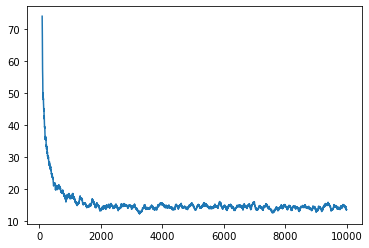

In [25]:
pd.Series(countlist).rolling(100).mean().plot.line()
pd.Series(countlist).mean()

3.5228383487535733

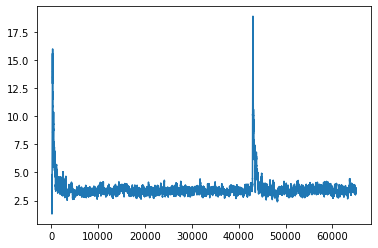

In [26]:
pd.Series(nav_times).rolling(100).mean().plot.line()
pd.Series(nav_times).mean()

In [27]:
def t(argument):
    switcher = {
        0: "root",
        1: "put",
        2: "get",
        3: "navigate",
        4: "pickup",
        5: "putdown",
        6: 'north',
        7: 'south',
        8: 'east',
        9: 'west'
    }
    return switcher.get(argument, "nothing")